# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait en groupe de 2 à 4. Aucun groupe de plus de 4 personnes. 

Vous allez rendre le TP dans une archive ZIP. L'archive ZIP contient ce notebook au format `ipynb`, mais aussi exporté en PDF & HTML. 
L'archive ZIP doit aussi contenir un fichier txt appelé `groupe.txt` sous le format:

```
Nom1, Prenom1, Email1, NumEtudiant1
Nom2, Prenom2, Email2, NumEtudiant2
Nom3, Prenom3, Email3, NumEtudiant3
Nom4, Prenom4, Email4, NumEtudiant4
```

Un script vient extraire vos réponses : ne changez pas l'ordre des cellules et soyez sûrs que les graphes sont bien présents dans la version notebook soumise. 

In [1]:
! pip install matplotlib tqdm numpy ipympl opencv-python torch tqdm
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-labextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtim

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

from tqdm import tqdm
from typing import List, Tuple
import typing as t
import math
import torch
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output
import random
import pandas as pd



torch.random.manual_seed(0)

K = 5 # num arms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Présentation du problème

In [3]:
import torch.testing


class ArmBernoulli:
    def __init__(self, p: float):
        """
        Vaccine treatment following a Bernoulli law (mean is p and variance is p(1-p)
        Args:
             p (float): mean parameter
             
        >>> torch.random.manual_seed(random_state)        
        >>> arm = ArmBernoulli(0.5)
        >>> arm.sample(5)
        tensor([ True, False,  True,  True,  True])
        """
        self.immunity_rate = p

    def sample(self, n: int = 1) -> torch.Tensor:
        return torch.rand(n) < self.immunity_rate
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.immunity_rate}' 

def generate_arms(num_arms: int):
    means = torch.rand(num_arms)
    # print("means =", means)
    MAB = [ArmBernoulli(m) for m in means]
    assert MAB[0].immunity_rate == means[0]
    assert (MAB[0].sample(10) <= 1).all() and (MAB[0].sample(10) >= 0).all() 
    return MAB

MAB = generate_arms(K)

Ce TP reprend l'exemple du médecin présenté en cours.


**Q1. Créez une fonction pour trouver $\mu^*$ à partir d'un `MAB`. Comment est définie la récompense $R_k$ ? Que représente concrètement le regret dans cet exemple ?**

In [4]:
def find_mean_reward_from_best_vaccin(MAB : List[ArmBernoulli], hide_immunity_rate = False) -> float:

    N = 1000
    means : List[float]
    
    if hide_immunity_rate:
        means = [torch.mean(arm.sample(N), dtype=float) for arm in MAB]
    else:
        means = [arm.immunity_rate for arm in MAB]
    
    print("means =", means)
    mu_star : float = max(means).item()
    print("mu_star =", mu_star)
    return mu_star

def apply_vaccin(arm : ArmBernoulli) -> int:
    """Rk
    
    Returns 1 if the patient is immunised thanks to the vaccin and 0 if not"""
    return 1 if arm.sample(1).item() else 0

def compute_regret(MAB : List[ArmBernoulli], N : int) -> float:
    mu_star = find_mean_reward_from_best_vaccin(MAB, False)
    # rn = N * mu_star - 

In [5]:
find_mean_reward_from_best_vaccin(MAB)

means = [tensor(0.4963), tensor(0.7682), tensor(0.0885), tensor(0.1320), tensor(0.3074)]
mu_star = 0.7682217955589294


0.7682217955589294

*[Ajoutez votre commentaire ici]*

**Que représente concrètement le regret dans cet exemple ?**

[Réponse] Le regret représente le nombre de patient qui aurait pu être immunisé si le meilleur avait été utilisé à chaque fois.

**Note importante :** pour la suite, les tests seront faits avec 10 MAB différents ou plus pour réduire le bruit de simulation. Concrètement, on exécutera au moins 10x `generate_arms`.

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. **Exploration :** N patients reçoivent une dose d'un vaccin choisi aléatoirement. Le médecin calcule le taux d'immunisation empirique :

$$\bar{R_i} = \frac{1}{T_i} \sum_{k=0}^{N-1} \chi_{v_k,i}R_k,$$

avec $T_i = \sum_{k=0}^{N-1} \chi_{v_k,i}$.


2. **Exploitation :** Le vaccin $v_i = \arg\max_j \bar{R_j}$ est utilisé pour les M patients suivants. C'est la phase de test.

**Q2. Implémentez la solution gloutonne avec N = 50 et M = 500 et testez la avec 100 MAB différents (tous ont 5 vaccins). On s'intéresse à la variable aléatoire "la phase d'exploration a trouvé le bon vaccin". Quelle est l'espérance empirique de cette variable ? Et son écart-type ? Calculez de même l'espérance et l'écart-type du regret sur vos 100 simulations.**

Pour rappel, le regret est défini par :

$$r_n = n\mu^* - \sum_{k=0}^{n-1} R_k$$

**Attention :** $n$ est le nombre total de patients, donc ici $N + M$.

In [6]:
MABs = [generate_arms(5) for _ in range(100)]

In [124]:
N = 50
M = 500
log = print if False else (lambda *_, **_2 : None)

In [152]:
def compute_empirical_immuniation_rate(vaccins_used : torch.Tensor, Rk : torch.Tensor, nb_vaccin : int) -> torch.Tensor:
    
    n_patients : int = vaccins_used.shape[0]

    vaccins_used = vaccins_used.to(torch.int)
    log("vaccins_used =", vaccins_used)

    log("Rk =", Rk)
    log("Rk shape =", Rk.shape)

    n_patient = vaccins_used.shape[0]
    assert(Rk.shape[0] == n_patient)

    # compute the number of times each vaccin has been used
    T = torch.bincount(vaccins_used, minlength=nb_vaccin)
    log("T =", T)
    
    # Compute the indicator function
    X = torch.zeros((n_patients, nb_vaccin))
    X[torch.arange(n_patients), vaccins_used] = 1
    log("X shape =", X.shape)
    # log("X :", X)

    Ris = torch.Tensor([1 / T[i] * (X[:,i] @ Rk) for i in range(nb_vaccin)]).flatten()
    log(Ris)

    # compute with bias
    C = 2
    bias = torch.sqrt(C * math.log(10) / T)
    print(bias)
    Ris_with_bias = Ris + bias
    log(Ris_with_bias)

    return Ris, Ris_with_bias


def exploration(MAB : List[ArmBernoulli], n_patients : int) -> tuple[torch.tensor, torch.tensor]:

    if n_patients == 0:
        return torch.Tensor(), torch.Tensor()

    nb_vaccin = len(MAB)

    log("Arms immunity rate :", [arm.immunity_rate for arm in MAB])

    # Vaccin used for all patients 
    vaccins_used = torch.randint(0, nb_vaccin, (n_patients,))

    # apply vaccins
    Rk = torch.cat([MAB[vaccins_used[k]].sample(1) for k in range(n_patients)]).flatten().to(torch.float)
    
    return vaccins_used, Rk

def compute_regret(n_success_exploration_vaccin : int, MAB : List[ArmBernoulli], real_best_vaccin : int, n_patients : int):

    max_vaccin = (n_patients * MAB[real_best_vaccin].immunity_rate).item()
    log("max_vaccin :", max_vaccin)

    return max_vaccin - n_success_exploration_vaccin

def exploitation_no_update(MAB : List[ArmBernoulli], exploration_best_vaccin : int, n_patients : int) -> int:
    """
    Returns:
        float: Number of patients that have been immune by a vaccin
    """

    # apply vaccin in exploitation
    n_success_exploration_vaccin = MAB[exploration_best_vaccin].sample(n_patients).sum().item()
    log("exploration_vaccin :", n_success_exploration_vaccin)

    return n_success_exploration_vaccin

def simulation(MAB : List[ArmBernoulli], n_patients_exploration : int, n_patients_exploitation : int) -> Tuple[bool, float]:
    """
    Returns:
        Tuple[bool, float]: Is vaccin found by exploration then TRUE | Regret of the exploitation
    """
               
    vaccins_used, Rk = exploration(MAB, n_patients_exploration)

    Ris, _ = compute_empirical_immuniation_rate(vaccins_used=vaccins_used, Rk=Rk, nb_vaccin=len(MAB))
    exploration_best_vaccin = Ris.argmax()
    log("exploration best vaccin :", exploration_best_vaccin)

    real_best_vaccin = np.array([arm.immunity_rate for arm in MAB]).argmax()
    log("real best vaccin :", real_best_vaccin)

    n_success_exploration_vaccin = exploitation_no_update(MAB, exploration_best_vaccin, n_patients=n_patients_exploitation)

    regret = compute_regret(n_success_exploration_vaccin, MAB, real_best_vaccin, n_patients_exploitation)
    log("Regret :", regret)

    return real_best_vaccin == exploration_best_vaccin, regret 

def print_results(samples_exploration_found_good_vaccin : torch.Tensor, exploitation_regrets : torch.Tensor) -> None:

    if samples_exploration_found_good_vaccin is not None:
        print("E_exploration_found_good_vaccin :", samples_exploration_found_good_vaccin.mean())
        print("std_exploration_found_good_vaccin :", samples_exploration_found_good_vaccin.std())

    print("E_exploitation_regrets :", exploitation_regrets.mean())
    std_exploitation_regrets = exploitation_regrets.std()
    print("std_exploitation_regrets :", std_exploitation_regrets)
    print("std_exploitation_regrets rate :", std_exploitation_regrets / M)

if False: # test with one simulation
    i = torch.randint(0, 100, (1, )).item()
    print("index :", i)
    simulation(MABs[i], N, M)

if True: # test with all the simulations
    
    l = torch.Tensor([simulation(MAB, N, M) for MAB in tqdm(MABs)])

    samples_exploration_found_good_vaccin = l[:, 0]
    exploitation_regrets = l[:, 1]

    print_results(samples_exploration_found_good_vaccin, exploitation_regrets)
    


  0%|          | 0/100 [00:00<?, ?it/s]

tensor([0.8111, 0.8111, 0.6195, 0.5735, 0.6786])
tensor([0.6786, 0.6786, 0.7153, 0.6470, 0.6786])
tensor([0.7587, 0.6470, 0.7587, 0.6786, 0.5952])
tensor([0.5541, 1.5174, 0.5952, 0.7587, 0.6195])
tensor([0.6786, 0.6786, 0.6195, 0.7587, 0.6786])
tensor([0.7153, 0.7153, 0.6195, 0.7153, 0.6470])
tensor([0.5952, 0.6786, 0.7587, 0.7153, 0.6786])
tensor([0.6195, 0.6786, 0.8111, 0.6195, 0.7153])
tensor([0.7153, 0.8761, 0.5735, 0.5952, 0.7587])
tensor([0.5735, 0.6786, 0.6195, 0.8111, 0.8111])
tensor([0.6470, 0.8761, 1.0730, 0.5541, 0.5735])
tensor([0.6195, 0.6786, 0.6786, 0.7153, 0.7153])
tensor([0.6195, 0.5952, 0.7587, 0.8761, 0.6470])
tensor([0.6195, 0.6195, 0.6470, 0.7587, 0.8111])
tensor([0.5952, 0.6470, 0.6786, 0.6786, 0.8761])
tensor([0.7153, 0.8111, 0.8761, 0.6786, 0.5058])
tensor([0.9597, 0.5952, 0.6195, 0.7153, 0.6470])
tensor([0.5952, 0.7587, 0.5952, 0.6470, 0.9597])
tensor([0.5952, 0.6786, 0.6786, 1.0730, 0.5952])
tensor([0.7587, 0.5541, 0.6786, 0.7587, 0.7153])
tensor([0.8111, 0.55

**Q3. On propose d'améliorer l'algorithme précédant en mettant à jour les taux d'immunisation empiriques $\bar{R}_i$ pendant l'exploitation. Notez vous une amélioration du regret ? Proposez un exemple dans lequel cette mise à jour ne changera rien.** 

In [164]:
def exploitation_update_immune_rate(MAB : List[ArmBernoulli], vaccins_used : torch.Tensor, Rk : torch.Tensor, n_patients : int, real_best_vaccin : int, add_bias : bool) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The immune rate for all vaccin at each iteration, same with bias, the regret at each iteration
    """

    sum = 0
    regrets = []
    list_Ris = []
    list_Ris_with_bias = []

    for k in range(n_patients):

        # Choose the vaccin considered as the best one
        Ris, Ris_with_bias = compute_empirical_immuniation_rate(vaccins_used=vaccins_used, Rk=Rk, nb_vaccin=len(MAB))
        best_vaccin = (Ris_with_bias if add_bias else Ris).argmax().to(torch.int)
        log("exploration best vaccin :", best_vaccin)
        list_Ris.append(Ris)
        list_Ris_with_bias.append(Ris_with_bias)

        # apply vaccin
        success = MAB[best_vaccin].sample(1)
        sum += success.item()

        # update vaccins_used and Rk
        vaccins_used = torch.cat((vaccins_used, torch.Tensor([best_vaccin])))
        Rk = torch.cat((Rk, success))

        # compute regret
        regret = compute_regret(sum, MAB, real_best_vaccin, k + 1)
        regrets.append(regret)

    return torch.stack(list_Ris), torch.stack(list_Ris_with_bias), torch.Tensor(regrets)

def simulation(MAB : List[ArmBernoulli], n_patients_exploration : int, n_patients_exploitation : int) -> float:
    """
    Returns:
        float: Regret of the exploitation
    """

    # exploration           
    vaccins_used, Rk = exploration(MAB, n_patients_exploration)

    # get the real best vaccin
    real_best_vaccin = np.array([arm.immunity_rate for arm in MAB]).argmax()
    log("real best vaccin :", real_best_vaccin)

    # exploitation
    _, _, regrets = exploitation_update_immune_rate(MAB, vaccins_used, Rk, n_patients_exploitation, real_best_vaccin, False)

    return regrets[-1]
    

In [165]:
# test with all the simulations
exploitation_regrets = torch.Tensor([simulation(MAB, N, M) for MAB in tqdm(MABs)])

print_results(None, exploitation_regrets)

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([0.6470, 0.5735, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.5541, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.5365, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.5205, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.5058, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4923, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4799, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4683, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4575, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4475, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4380, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4292, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4209, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4130, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.4055, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.3985, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.3918, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.3854, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.3794, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.3736, 0.5952, 0.7153, 1.2390])
tensor([0.6470, 0.36

KeyboardInterrupt: 

*[Ajoutez votre commentaire ici]*

- *Notez vous une amélioration du regret ?*

Oui, nous observons une nette observation du regret.

- *Proposez un exemple dans lequel cette mise à jour ne changera rien.*

Cette mise à jour ne sert à rien lorsque le meilleur vaccin a été trouvé lors de l'exploration et que mettre à jour les taux d'immunsation des vaccins ne fait pas changer le vaccin qui est considéré comme le plus performant.

**Q4. Créez une figure contenant deux sous-figures : à gauche, le taux d'immunisation empirique $\bar{R}_i$ pour les 5 vaccins ; à droite, le regret $r_n$. La figure sera animée avec les patients : chaque frame $k$ de l'animation représente le vaccin que l'on donne au $k$-ième patient.**

In [199]:
def simulation(MAB : List[ArmBernoulli], n_patients_exploration : int, n_patients_exploitation : int, add_bias : bool) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The immune rate for all vaccin at each iteration, , the regret at each iteration
    """

    # exploration           
    vaccins_used, Rk = exploration(MAB, n_patients_exploration)

    # get the real best vaccin
    real_best_vaccin = np.array([arm.immunity_rate for arm in MAB]).argmax()
    log("real best vaccin :", real_best_vaccin)

    # exploitation
    return exploitation_update_immune_rate(MAB, vaccins_used, Rk, n_patients_exploitation, real_best_vaccin, add_bias)

def plot_a_simulation(MAB : List[ArmBernoulli], n_patients_exploration : int = N, n_patients_exploitation : int = M, add_bias : bool = False) -> None:

    print("Immunity rates :", [round(arm.immunity_rate.item(), 3) for arm in MAB])
    
    list_Ris, list_Ris_with_bias, regrets = simulation(MAB, n_patients_exploration, n_patients_exploitation, add_bias)

    # store Tensor in a dataframe
    df_Ris = pd.DataFrame(list_Ris, columns=[f"nu{i}" for i in range(len(MABs[0]))])
    df_Ris_with_bias = pd.DataFrame(list_Ris_with_bias, columns=[f"nu{i}_bias" for i in range(len(MABs[0]))])
    df_regrets = pd.DataFrame(regrets, columns=["regrets"])
    
    _, axes = plt.subplots(1, 2, figsize=(20, 10))
    colors=["red", "blue", "green", "purple", "orange"]
    df_Ris.plot(kind="line", ax=axes[0], color=colors)
    if add_bias:
        df_Ris_with_bias.plot(kind="line", ax=axes[0], linestyle='--', color=colors)
    df_regrets.plot(kind="line", ax=axes[1])

Immunity rates : [0.553, 0.953, 0.036, 0.185, 0.373]
tensor([0.5365, 0.7153, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.6786, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.6470, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.6195, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.5952, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.5735, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.5541, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.5365, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.5205, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.5058, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.4923, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.4799, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.4683, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.4575, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.4475, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.4380, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.4292, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.4209, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 0.4130, 0.8761, 0.7587, 0.6470])
tensor([0.5365, 

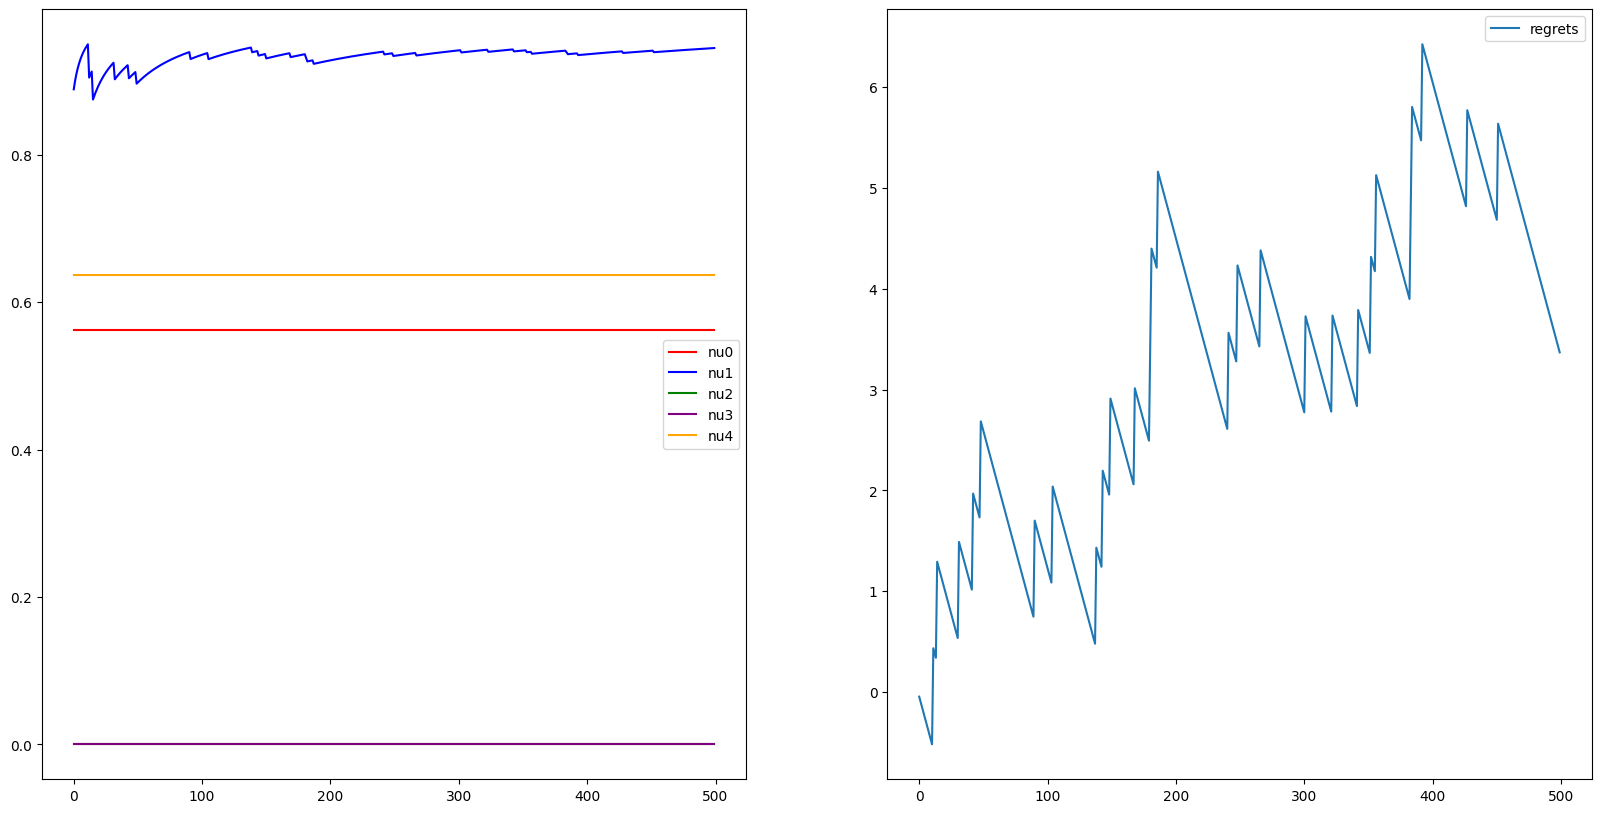

In [200]:
# The vaccin used does not changes because the best vaccin is way much too good.
plot_a_simulation(MAB=MABs[0])

In [142]:
def generate_custom_arms(min_rate : float, diff_rate : float):
    MAB = generate_arms(5)
    for k, arm in enumerate(MAB):
        arm.immunity_rate = torch.Tensor([min_rate + diff_rate * k])

    return MAB

Immunity rates : [0.3, 0.31, 0.32, 0.33, 0.34]


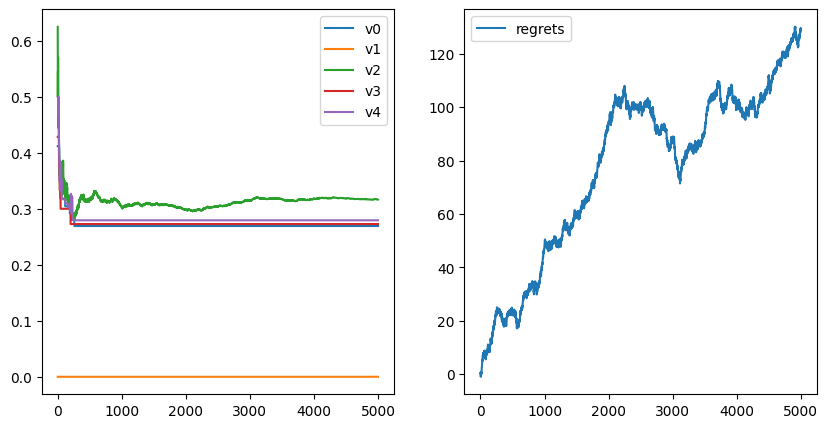

In [143]:
# The immunity rates are very close so each run change a lot the curves because 50 patients for the exploration is too low.
MAB = generate_custom_arms(0.3, 0.01)
plot_a_simulation(MAB=MAB, n_patients_exploitation=5000)

*[Ajoutez votre commentaire ici]*

When the best vaccin is found, the regret does not grow too much.
When it is not found, the regret grows infinitely.

**Q5. On étudie maintenant l'influence de la taille du training set $N$. On considère que N+M est une constante, puis on fait varier N entre K et M. Calculez le regret pour ces différentes tailles du training set  différents MAB et representez le regret moyen, le regret min et max (vous devriez trouver une courbe en U ou en V pour le regret moyen). Quelle est la taille optimale du training set ?**

In [90]:
O = N + M
K = 10

MAB = generate_custom_arms(.3, 0.01)

list_min_max_mean = []

for nb_patiens_exploration in tqdm(range(K, O)):
    nb_patiens_exploitation = O - nb_patiens_exploration
    _, regrets = simulation(MAB, nb_patiens_exploration, nb_patiens_exploitation)

    list_min_max_mean.append((regrets.min().item(), regrets.max().item(), regrets.mean().item()))

list_min_max_mean

  0%|          | 0/540 [00:00<?, ?it/s]

[(tensor(-11.3600), tensor(6.9400), tensor(-2.5596)),
 (tensor(-5.7600), tensor(20.7000), tensor(4.8631)),
 (tensor(-6.9200), tensor(12.6400), tensor(2.6319)),
 (tensor(-7.6200), tensor(4.6400), tensor(-1.6331)),
 (tensor(-4.8600), tensor(12.2400), tensor(5.0568)),
 (tensor(-5.2200), tensor(13.2800), tensor(3.7518)),
 (tensor(-6.7000), tensor(19.), tensor(5.5586)),
 (tensor(-1.9600), tensor(25.2200), tensor(13.3335)),
 (tensor(-3.0600), tensor(10.8800), tensor(3.6326)),
 (tensor(-2.4200), tensor(21.2600), tensor(8.5681)),
 (tensor(-4.1000), tensor(13.1600), tensor(2.7002)),
 (tensor(-1.3000), tensor(13.6800), tensor(5.2664)),
 (tensor(-3.7400), tensor(15.1800), tensor(6.0796)),
 (tensor(-8.5600), tensor(3.4200), tensor(-2.8548)),
 (tensor(-25.3400), tensor(0.3600), tensor(-14.6971)),
 (tensor(-1.8000), tensor(22.9800), tensor(11.4390)),
 (tensor(-1.3400), tensor(24.1400), tensor(10.3187)),
 (tensor(-5.1400), tensor(18.4800), tensor(8.9270)),
 (tensor(-2.5200), tensor(10.5000), tensor(5

<Axes: xlabel='N'>

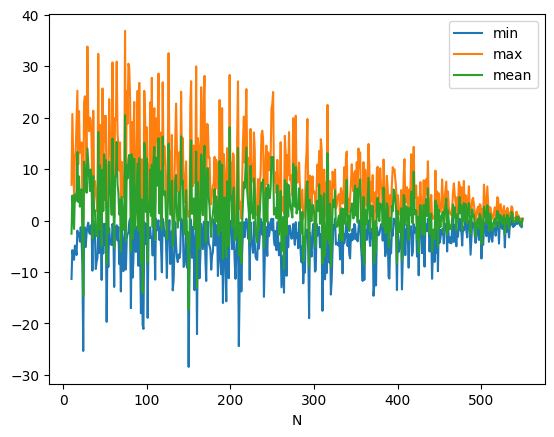

In [101]:
# convert list to dataframe
df = pd.DataFrame(list_min_max_mean, columns=["min", "max", "mean"], index=list(range(K, O)))

# plot
df.plot(kind="line", xlabel="N")

*[Ajoutez votre commentaire ici]*

The lower is the number of patients in exploration (N), the higher is the risk of choosing the wrong vaccin.
The regret can steel be low when N is low because the best vaccin can be found by "luck".

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Lai et Robbins [Lai et Robbins, 1985] considère une classe d'algorithmes $\pi$ pour résoudre ce type de problèmes.

Ils ont trouvé une borne inférieure sur les récompenses cumulées en valeur asymptotique :

$$\lim_{n\rightarrow \infty} \inf_{\pi} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)}  :=C(\mu)$$
 
 avec $\text{KL}(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ (distance de Kullback-Leibler) et  $\sum_{k=0}^{n-1} R_k$ la récompense obtenue sur $n$ patients.
 
 
**Q6. Justifiez pourquoi on peut en déduire que le regret d'un algorithme raisonnable sera au pire logarithmique.**

*[Ajoutez votre commentaire ici]*

**Q7. Tracez le regret issu de la borne de Lai & Robbins et comparez le au regret obtenu avec l'algorithme glouton.**

*[Ajoutez votre commentaire ici]*

## I.c. Upper Confidence Bounds

Cet algorithme améliore la version précédente en ajoutant un biais lié à la fréquentation de chaque vaccin :

$\bar{\mu}_i = \hat{\mu}_i + \sqrt{\frac{C\log{n}}{T_i}}$,

avec $C=2$.


**Q8. Implémentez la modification de cet algorithme. Observez un intérêt à conserver $N > 0$ ? Et $\epsilon < 1$ ? Expliquez pourquoi.**

Dans la suite, on prendra $N = 0$ et $\epsilon = 1$.

Immunity rates : [0.1, 0.3, 0.5, 0.7, 0.9]
tensor([inf, inf, inf, inf, inf])
tensor([2.1460,    inf,    inf,    inf,    inf])
tensor([2.1460, 2.1460,    inf,    inf,    inf])
tensor([2.1460, 2.1460, 2.1460,    inf,    inf])
tensor([2.1460, 2.1460, 2.1460, 2.1460,    inf])
tensor([2.1460, 2.1460, 2.1460, 2.1460, 2.1460])
tensor([2.1460, 1.5174, 2.1460, 2.1460, 2.1460])
tensor([2.1460, 1.5174, 2.1460, 2.1460, 1.5174])
tensor([2.1460, 1.5174, 2.1460, 2.1460, 1.2390])
tensor([2.1460, 1.5174, 2.1460, 2.1460, 1.0730])
tensor([1.5174, 1.5174, 2.1460, 2.1460, 1.0730])
tensor([1.5174, 1.5174, 1.5174, 2.1460, 1.0730])
tensor([1.5174, 1.5174, 1.5174, 1.5174, 1.0730])
tensor([1.5174, 1.5174, 1.5174, 1.5174, 0.9597])
tensor([1.5174, 1.2390, 1.5174, 1.5174, 0.9597])
tensor([1.5174, 1.2390, 1.5174, 1.2390, 0.9597])
tensor([1.5174, 1.2390, 1.5174, 1.2390, 0.8761])
tensor([1.5174, 1.0730, 1.5174, 1.2390, 0.8761])
tensor([1.5174, 1.0730, 1.5174, 1.0730, 0.8761])
tensor([1.5174, 1.0730, 1.5174, 1.0730, 0

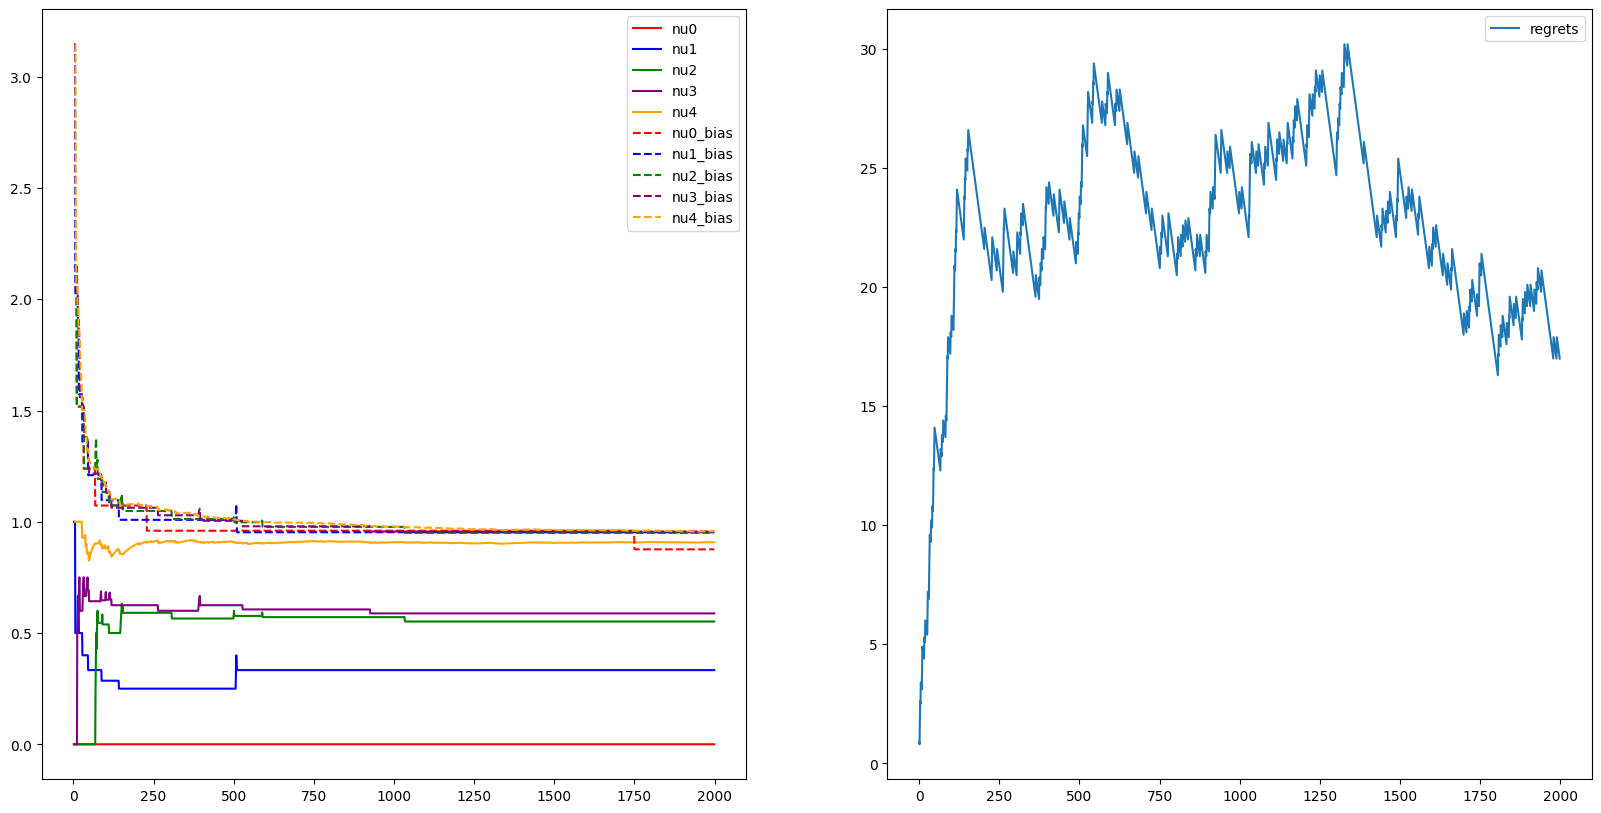

In [201]:
MAB = generate_custom_arms(0.1, 0.2)
plot_a_simulation(MAB, n_patients_exploration=0, n_patients_exploitation=2000, add_bias=True)

*[Ajoutez votre commentaire ici]*
There no use anymore of an exploration because even in exploitation the vaccin used change often because of the bias.

**Q9. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez $\bar{\mu}_i$ et $\hat{\mu}_i$ pour chaque vaccin.**

*[Ajoutez votre commentaire ici]*
See higher

**Q10. Reprenez la question Q5 avec cette algorithme. Concluez sur l'utilité (ou l'inutilité) de la phase d'exploration. Comparez les performances d'UCB avec celles de l'algorithme glouton.**

*[Ajoutez votre commentaire ici]*

**Q11. Testez différentes valeurs pour $C$ et trouvez sa valeur optimale expérimentalement.**

*[Ajoutez votre commentaire ici]*

# Echantillonnage de Thomson

Cet algorithme propose de modéliser la variable aléatoire de chaque vaccin avec une loi $\beta$ dont les paramètres $a$ et $b$ correspondent au nombre de patients que le vaccin a immunisés (resp. non immunisés).

Pour chaque patient, on tire un valeur aléatoire pour la loi $\beta$ décrivant chaque vaccin, puis on choisit le vaccin avec la plus grande valeur tirée. 

**Q12. Implémentez cet algorithme. En testant plusieurs valeurs de $N$, montrez que la phase d'exploration précédente a un impact très limité. Cela veut-il dire que l'algorithme ne contient pas d'initialisation ?**

*[Ajoutez votre commentaire ici]*

**Q13. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez le taux d'immunisation empirique  pour chaque vaccin avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot) qui représente la loi beta associée à chaque vaccin.**

*[Ajoutez votre commentaire ici]*

**Q14. Comparez le regret avec les autres algorithmes.**

*[Ajoutez votre commentaire ici]*

# Conclusion

**Q15. Calculez le regret des algorithmes glouton, UCB & Thomson lorsqu'il y a un grand nombre de vaccins disponibles (K=100) (on prendra N=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**